In [2]:
# JupySQL Plotting with DuckDB
# https://duckdb.org/2023/02/24/jupysql.html

!pip install pyarrow
!pip install fastparquet

In [3]:
%%time

import os
from urllib.request import urlretrieve
import pandas as pd

my_file = 'data/test_excel_output.xlsx'
if os.path.exists(my_file):
    print('parquet tets file:%s exist.' %my_file)
else:
    #执行下载任务，保存到data目录
    _ = urlretrieve("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet",  "data/yellow_tripdata_2022-01.parquet")

import pyarrow.parquet as pq

print(f"Data frame takes")        
df = pd.read_parquet("data/yellow_tripdata_2022-01.parquet", engine='auto', columns=None, use_nullable_dtypes=False)
df_mb = df.memory_usage().sum() / (1024 ** 2)
print(f"Data frame takes {df_mb:.0f} MB") 

#所以将CSV类型转换成parquet可以变得更快，更小；   

import matplotlib.pyplot as plt

plt.boxplot(df.trip_distance)
_ = plt.title("Trip distance")



parquet tets file:data/test_excel_output.xlsx exist.
Data frame takes


<timed exec>:15: FutureWarning: The argument 'use_nullable_dtypes' is deprecated and will be removed in a future version.


ArrowMemoryError: malloc of size 78845824 failed

In [1]:
%load_ext sql
%sql duckdb://

%sql select * from 'data/yellow_tripdata_2022-01.parquet' LIMIT 3

Connecting to 'duckdb://'

Running query in 'duckdb://'

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0


In [18]:
%reload_ext sql
%sql duckdb://

In [23]:
%%sql
SELECT count(1) as 数据量 
FROM "data/yellow_tripdata_2022-01.parquet"

Running query in 'duckdb://'

数据量
2463931


In [24]:
%%sql
-- We calculate the percentiles all at once and 
-- then convert from list format into separate columns
-- (Improving performance by reducing duplicate work)
WITH stats AS (
  SELECT
    percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP 
      (ORDER BY "trip_distance") AS percentiles
  FROM "data/yellow_tripdata_2022-01.parquet"
)
SELECT
  percentiles[1] AS q1,
  percentiles[2] AS median,
  percentiles[3] AS q3
FROM stats;


Running query in 'duckdb://'

q1,median,q3


<Axes: title={'center': "'trip_distance' from 'data/yellow_tripdata_2022-01.parquet'"}, ylabel='trip_distance'>

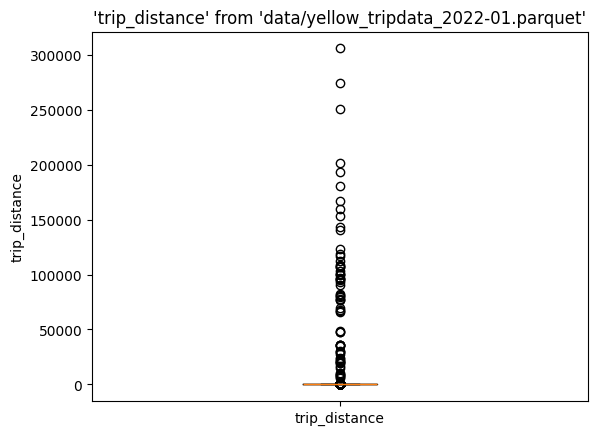

In [26]:
%sqlplot boxplot --table data/yellow_tripdata_2022-01.parquet --column trip_distance

In [27]:
%%sql
SELECT percentile_disc(0.99) WITHIN GROUP (ORDER BY trip_distance)
FROM 'data/yellow_tripdata_2022-01.parquet'

Running query in 'duckdb://'

quantile_disc(0.99 ORDER BY trip_distance)
19.7


In [34]:
%%sql --save no_outliers --no-execute
SELECT *
FROM 'data/yellow_tripdata_2022-01.parquet'
WHERE trip_distance < 19.7

Running query in 'duckdb://'

Skipping execution...

<Axes: title={'center': "'trip_distance' from 'no_outliers'"}, ylabel='trip_distance'>

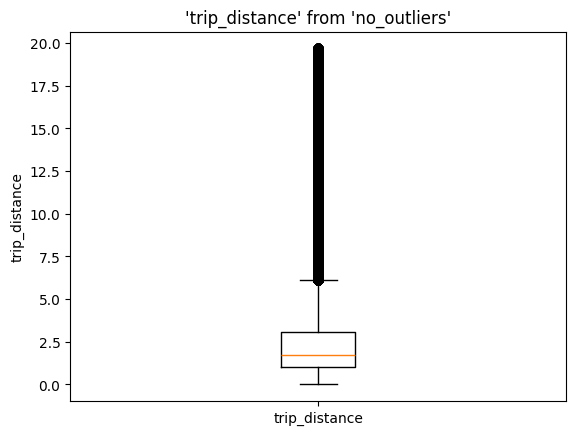

In [35]:
%sqlplot boxplot --table no_outliers --column trip_distance --with no_outliers

<Axes: title={'center': "'trip_distance' from 'no_outliers'"}, xlabel='trip_distance', ylabel='Count'>

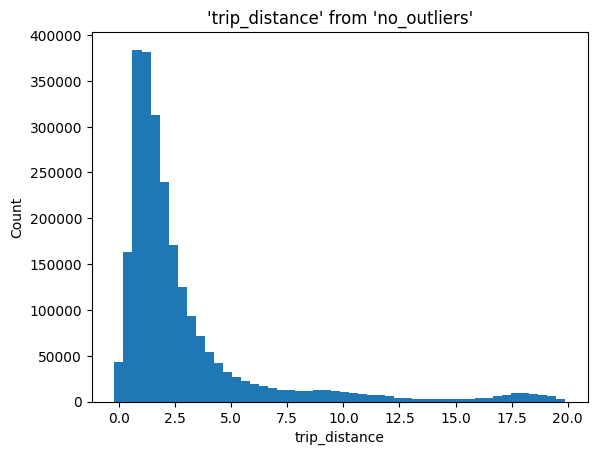

In [40]:
%sqlplot histogram --table no_outliers --column trip_distance --with no_outliers
